# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

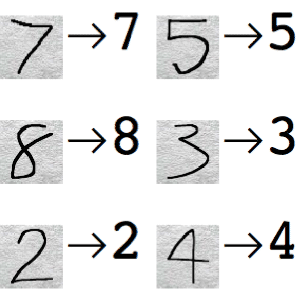

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

11490434/11490434 [==============================] - 2s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


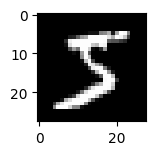

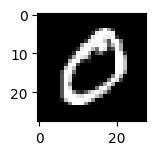

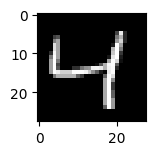

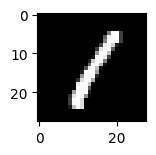

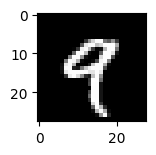

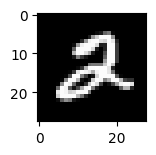

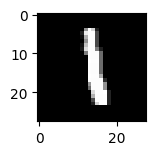

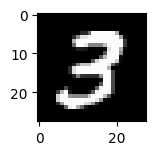

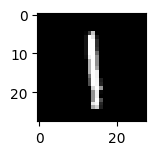

In [1]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [2]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [3]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [4]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [5]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [7]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [8]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [9]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.700
> 98.492
> 98.575
> 98.850
> 98.700


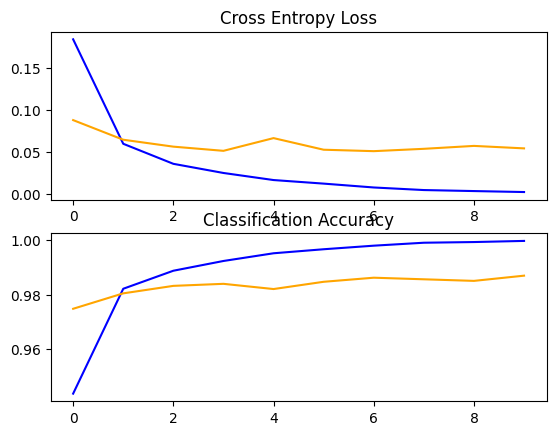

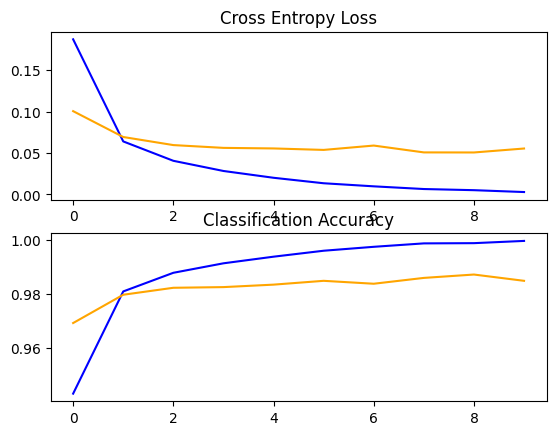

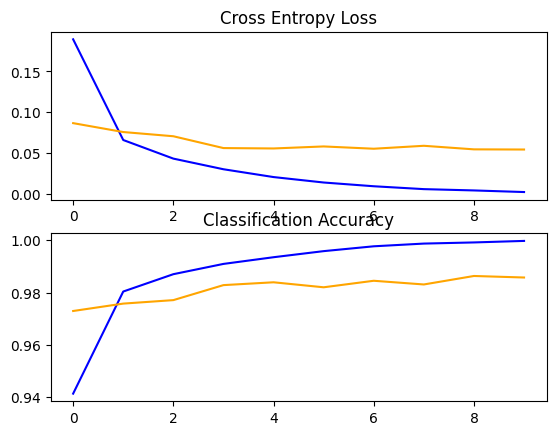

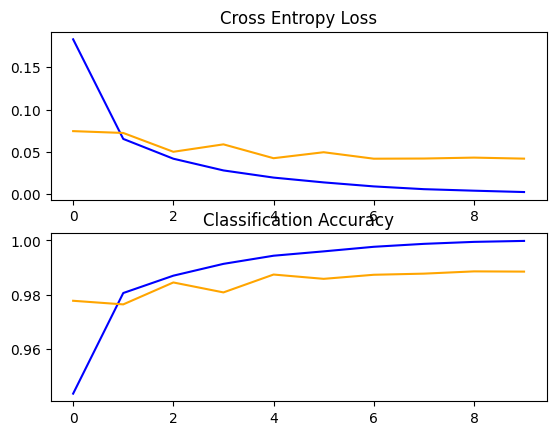

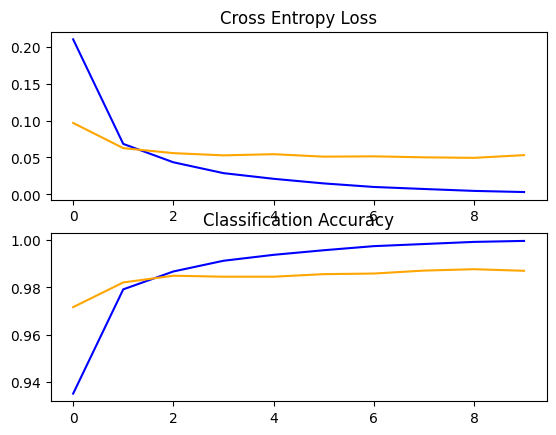

Accuracy: mean=98.663 std=0.122, n=5


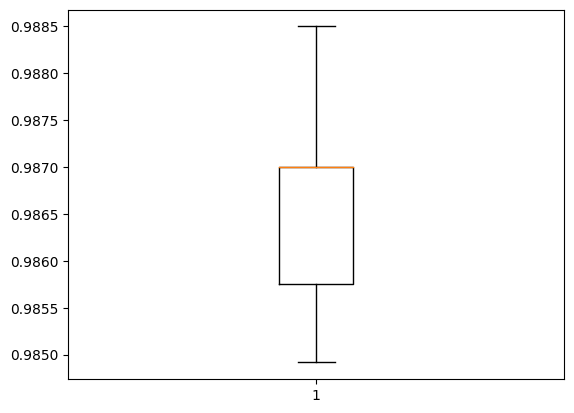

In [10]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [11]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

In [12]:
run_test_harness2()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate Final Model

## Make Prediction

In [14]:
import numpy as np

def load_image(filename):
  # load the image
  img = load_img(filename, grayscale=True, target_size=(28, 28))

  # convert to array
  img = img_to_array(img)

  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)

  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0


  ###START
  ###CODE em thêm ở đây ạ (em biết đến các kiến thức này vì em từng được tham gia 1 cuộc thi và đây là tài liệu cuộc thi đó: https://via.makerviet.org/vi/ebook/VIA-Ebook-1.0.pdf)
  img = 1.0 - img # Sau khi chuẩn hóa ảnh về [0, 1] trên ảnh xám, giá trị điểm ảnh 0 đại diện cho màu đen và giá trị 1 đại diện cho màu trắng
                  # và ảnh trong data của chúng em sẽ có dạng nền trắng chữ đen.
                  # Vậy nên em sử dụng phép tính này để đổi màu ngược lại cho ảnh cho phù hợp dữ liệu model đã học (nền đen chữ trắng)


  # Tạo độ tương phản cho ảnh để các nét của số và nền được tương phản rõ hơn (trang 80 của file pdf trên)
  threshold=0.3 # Em chọn 0.3 vì nó cho kết quả khá ổn định thông qua nhiều lần thử nghiệm với các giá trị khác (thử tay)
  img[img < threshold] *= 0.5  # Với những điểm ảnh nhỏ hơn threshold (gần với 0), em sẽ nhân với 0.5 để làm cho các điểm ảnh này gần 0 hơn nữa (đen hơn)
  img[img >= threshold] *= 1.5  # Với những điểm ảnh lớn hơn threshold (gần với 1), em sẽ nhân với 1.5 để làm cho các điểm ảnh này gần 1 hơn nữa (trắng hơn)
  # Các giá trị 0.5 và 1.5 được chọn sau khi đã thử nghiệm nhiều lần với các giá trị khác nhau (thử tay)


  # Với các điểm ảnh lớn hơn threshold, sau khi nhân với 1.5 thì các điểm ảnh này có thể lớn 1
  # vì vậy em dùng câu lệnh dưới đây để đảm bảo giá trị điểm ảnh nằm trong khoảng [0, 1]
  img = np.clip(img, 0, 1) # Em sử dụng gpt với câu lệnh: "How to limit pixel in img using python"
  ###END

  return img

In [15]:
# Em sửa hàm run_example để có thể lấy ra tất cả các ảnh theo cấu trúc file thầy đã yêu cầu
import os
from numpy import argmax

def run_example():
  main_dir="data"
  correct=0
  total=0

  # load model
  model = load_model('final_model.h5')

  for mssv in sorted(os.listdir(main_dir)): # Duyệt qua các tất cả thư mục mã sinh viên
    mssv_path= os.path.join(main_dir,mssv)
    for label in range(10):   # Duyệt qua các thư mục từ 0 đến 9 trong mỗi thư mục mssv
      label_path=os.path.join(mssv_path,str(label))
      for img_file in os.listdir(label_path): # Lấy tất cả các ảnh
        img_path= os.path.join(label_path,img_file)
        img=load_image(img_path)

        # predict the class
        predict_value = model.predict(img,verbose=0)
        digit = argmax(predict_value)
        if digit==int(label):
          correct+=1
        total+=1
  acc=correct/total
  print(f"Accuracy: {acc*100:.2f}%")


In [17]:
# entry point, run the example
run_example()

Accuracy: 95.00%
